In [64]:
import pandas as pd
import numpy as np
from lib import raw_ds_columns, calc_ts_diff
from visualization import display_point_process_events
from scipy.optimize import minimize
from tick.hawkes import HawkesSumExpKern, HawkesBasisKernels, HawkesKernelTimeFunc, SimuHawkes
import statsmodels
from scipy import integrate
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import statsmodels.api as sm
import itertools

plt.style.use('ggplot')

import numpy as np
import pandas as pd 
from tick.hawkes import *
from scipy.optimize import *
from tick.plot import plot_hawkes_kernels

In [66]:
def periodic_boundary_condition(ts_df):
    copy_ = ts_df.copy()
    copy_["Bid_time"] = copy_["Bid_time"] + max(copy_["Bid_time"]) + 1
    return pd.concat([ts_df, copy_])

def csv_reader(name):
    df = pd.read_csv("data/{}".format(name),header=None)

    df.set_index(0)

    df.drop(df.columns[0], axis = 1, inplace=True)
    df.columns = df.iloc[0]
    df = df.iloc[1:]

    df["Bid_time"] = df["Bid_time"].astype(float)
    df["Mid_IV"] = df["Mid_IV"].astype(float)
    df["Mid_price"] = df["Mid_price"].astype(float)
    
#     df["Bid_time"] = df["Bid_time"] - min(df["Bid_time"])
#     df = periodic_boundary_condition(df)
    df.reset_index(drop=True, inplace=True)
    return df
    

In [67]:
n_minus_ts_ticks_25dc = csv_reader('n_plus_ts_ticks_60dc_AAPL.csv')
n_minus_ts_ticks_25dp = csv_reader('n_plus_ts_ticks_60dp_AAPL.csv')
n_minus_ts_ticks_50dc = csv_reader('n_minus_ts_ticks_50dc_AAPL.csv')

n_plus_ts_ticks_25dc = csv_reader('n_plus_ts_ticks_60dc_AAPL.csv')
n_plus_ts_ticks_25dp = csv_reader('n_plus_ts_ticks_60dp_AAPL.csv')
n_plus_ts_ticks_50dc = csv_reader('n_plus_ts_ticks_50dc_AAPL.csv')
# n_plus_ts_ticks_50dc = n_plus_ts_ticks_50dc.iloc[1:]

In [68]:
n_plus_ts_ticks_50dc.head()

,Bid_time,Price_strike,Mid_price,Underlying_mid_price,Mid_IV,Delta,Mid_price_diff,Bid_time_diff,Mid_IV_diff,Mid_price_ret,Mid_IV_diff_sign
0,94200005.0,312.5,8.900000,313.065,0.239198,0.524195093765023,0.07500000000000107,1.0,0.0020840400048439955,0.008462673918733728,1.0
1,94200035.0,312.5,8.925000,313.065,0.239892,0.5242048554894296,0.025000000000000355,30.0,0.0006946820244257967,0.0028050509276086816,1.0
2,94200100.0,312.5,8.925000,313.055,0.240038,0.5240233554987483,0.02500000000000213,22.0,0.000694685038314713,0.0028050509276089032,1.0
3,94200141.0,311.07142857142856,9.721429,313.035,0.242260,0.549715893659819,0.821428571428573,12.0,0.002916488373954751,0.08828130330406775,1.0
4,94200157.0,311.25,9.631250,313.01,0.242718,0.5459793553394654,0.71875,13.0,0.0028084524075742967,0.07755823434587444,1.0


In [69]:
all_data = [
    n_plus_ts_ticks_25dc, n_minus_ts_ticks_25dc,
            n_plus_ts_ticks_50dc, n_minus_ts_ticks_50dc,
            n_plus_ts_ticks_25dp, n_minus_ts_ticks_25dp,
]

all_timestamps = []
for df in all_data:
    all_timestamps.append(np.array(list(df['Bid_time'])))
    

In [70]:
all_timestamps

[array([94200151., 94200153., 94200227., 94200247., 94200304., 94200315.,
        94200340., 94200381., 94200401., 94200432., 94200444., 94200467.,
        94200485., 94200529., 94200536., 94200543., 94200557., 94200594.,
        94200626., 94200638., 94200717., 94200746., 94200757., 94200758.,
        94200832., 94201011., 94201185., 94201641., 94201938., 94201985.,
        94202167., 94202220., 94202298., 94202301., 94202308., 94202316.,
        94202450., 94202477., 94202500., 94202516., 94202540., 94202544.,
        94202691., 94202819., 94202821., 94202824., 94202850., 94202857.,
        94203028., 94203043., 94203076., 94203080., 94203084., 94203121.,
        94203156., 94203158., 94203159., 94203170., 94203178., 94203217.,
        94203249., 94203274., 94203279., 94203307., 94203439., 94203470.,
        94203504., 94203685., 94203780., 94203800., 94203856., 94203904.,
        94203929., 94203946., 94203975., 94203978., 94204063., 94204077.,
        94204086., 94204103., 94204104

In [71]:
def fun(decays, events = all_timestamps):
        return - HawkesExpKern(decays=decays[0], penalty='elasticnet', tol=1e-8,
                          elastic_net_ratio=0.9, max_iter=1000).fit(events).score()

In [ ]:
start = 0.1
end = 0.9
N = 20

decays = np.linspace(start,end,N)
# max_score = 0.02851080438470447
max_score = -1e7
best_beta = 0.18784562

for i in range(N):
    x0 = decays[i]
    result = minimize(fun, x0 = [x0], method = 'Nelder-Mead', tol =1e-10)
    score = -result.fun
    if  score > max_score:
        max_score = score
        best_beta = result.x
        print(f"Iteration: {i}")
        print(f"Highest likelihood: {max_score}")
        print(f"Best beta value: {best_beta}")

# Highest likelihood: 0.02851080438470447
# Best beta value: [0.18784562]


/home/eugene/PycharmProjects/HPVol/venv/lib/python3.6/site-packages/tick/solver/agd.py:144: RuntimeWarning: overflow encountered in multiply
  + 1. / (2 * step) * norm(x - y) ** 2
/home/eugene/PycharmProjects/HPVol/venv/lib/python3.6/site-packages/tick/solver/agd.py:144: RuntimeWarning: overflow encountered in double_scalars
  + 1. / (2 * step) * norm(x - y) ** 2


Step equals 0... at 0
Step equals 0... at 0
Step equals 0... at 0
Iteration: 0
Highest likelihood: 0.004429918614957006
Best beta value: [0.00989416]


/home/eugene/PycharmProjects/HPVol/venv/lib/python3.6/site-packages/tick/solver/agd.py:155: RuntimeWarning: invalid value encountered in multiply
  y[:] = x + (prev_t - 1) / t * (x - prev_x)


Step equals 0... at 0
Step equals 0... at 0
Step equals 0... at 0
Iteration: 1
Highest likelihood: 0.004429918614957024
Best beta value: [0.00989415]
Step equals 0... at 0
Step equals 0... at 0
Step equals 0... at 0
Step equals 0... at 0
Step equals 0... at 0
Step equals 0... at 0
Step equals 0... at 0
Step equals 0... at 0
Step equals 0... at 0
Step equals 0... at 0
Step equals 0... at 0
Step equals 0... at 0
Step equals 0... at 0
Step equals 0... at 0
Step equals 0... at 0
Iteration: 5
Highest likelihood: 0.004429918614957038
Best beta value: [0.00989416]
Step equals 0... at 0
Step equals 0... at 0
Step equals 0... at 0
Iteration: 6
Highest likelihood: 0.004429918614957051
Best beta value: [0.00989416]
Step equals 0... at 0
Step equals 0... at 0
Step equals 0... at 0
Step equals 0... at 0
Step equals 0... at 0
Step equals 0... at 0


In [25]:
best_beta

array([0.09850167])

In [26]:
# best_beta = [0.18784562]
BEST_BETA = best_beta[0]

learner = HawkesExpKern(decays=BEST_BETA,tol=1e-10, penalty='elasticnet', 
                          elastic_net_ratio=0.9, max_iter=2000)

learner.fit(all_timestamps)

alphas = learner.adjacency
betas = learner.decays
baseline = learner.baseline
loglik = learner.score()

print("Alphas: ")
print(np.round(alphas,4))

print("\n Baseline: ")
print(baseline)

print("\n Endogeneity:")
print(max(np.linalg.eigvals(alphas)))

print("\n Likelihood: ")
print(loglik)

Alphas: 
[[0.2323 0.2323 0.0275 0.0151 0.0039 0.0039]
 [0.2323 0.2323 0.0275 0.0151 0.0039 0.0039]
 [0.0703 0.0703 0.0597 0.3258 0.0496 0.0496]
 [0.0798 0.0798 0.3923 0.0415 0.0461 0.0461]
 [0.0023 0.0023 0.0391 0.0396 0.1272 0.1272]
 [0.0023 0.0023 0.0391 0.0396 0.1272 0.1272]]

 Baseline: 
[0.00031338 0.00031338 0.00081125 0.00080102 0.00089916 0.00089916]

 Endogeneity:
0.5333685751915279

 Likelihood: 
0.013932989623314027


In [55]:
def resid(x, intensities, timestamps, dim, method):
    print(dim)
    arrivals = timestamps[dim]
    print(arrivals[:20])
    thetas = np.zeros(len(arrivals) - 1)
    ints = intensities[dim]
    print(ints[:20])
    for i in range(1, len(arrivals)):
        mask = (x <= arrivals[i]) & (x >= arrivals[i - 1])
        xs = x[mask]
        ys = ints[mask]
        try:
            thetas[i - 1] = method(ys, xs)
        except:
            thetas[i - 1] = np.nan

    return thetas

def goodness_of_fit_par(learner, arrivals, step, method):
    dimension = learner.n_nodes
    intensities = learner.estimated_intensity(arrivals, step)[0]
    x = learner.estimated_intensity(arrivals, step)[1]
    residuals = [resid(x, intensities, arrivals, dim, method) for dim in range(dimension)]
    return residuals

def ks_test(resid):
    for res in resid:
        print(stats.kstest(res[np.logical_not(np.isnan(res))], 'expon'))

def plot_resid(resid, rows, cols):
    fig, axes = plt.subplots(nrows=rows, ncols=cols)
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle('Goodness-of-fit for nonparametric HP')

    for ax, res in zip(axes, resid):
        k = stats.probplot(res, dist=stats.expon, fit=True, plot=ax, rvalue=False)
        ax.plot(k[0][0], k[0][0], 'k--')

def ks_test(resid):
    return [
        stats.kstest(res[np.logical_not(np.isnan(res))], 'expon')
        for res in resid
    ]

def lb_test(resid):
    return [
        sm.stats.acorr_ljungbox(res[np.logical_not(np.isnan(res))], lags=[3], return_df=True)
        for res in resid
    ]

def ed_test(resid):
    results = []
    for res in resid:
        res_ = res[np.logical_not(np.isnan(res))]
        results.append(
            np.sqrt(len(res_)) * (np.var(res_, ddof=1) - 1) / np.sqrt(8)
        )
    return results

In [58]:
t_min = min([min(ts) for ts in all_timestamps])
t_max = max([max(ts) for ts in all_timestamps])

offset_timestamps = [ts - t_min for ts in all_timestamps]

residuals = goodness_of_fit_par(learner, offset_timestamps, 1, integrate.trapz)

0
[ 185.  713.  719.  723.  725.  726.  759.  887.  922.  932.  954.  999.
 1104. 1460. 1794. 1810. 1813. 1817. 1825. 1907.]
[0.00031338 0.00166142 0.00153497 0.00424759 0.00387854 0.00354411
 0.00324105 0.00296642 0.00271755 0.00249202 0.00228765 0.00210246
 0.00193463 0.00178255 0.00164473 0.00151984 0.00140667 0.00130411
 0.00121118 0.00112696]
1
[ 185.  713.  719.  723.  725.  726.  759.  887.  922.  932.  954.  999.
 1104. 1460. 1794. 1810. 1813. 1817. 1825. 1907.]
[0.00031338 0.00166142 0.00153497 0.00424759 0.00387854 0.00354411
 0.00324105 0.00296642 0.00271755 0.00249202 0.00228765 0.00210246
 0.00193463 0.00178255 0.00164473 0.00151984 0.00140667 0.00130411
 0.00121118 0.00112696]
2
[   2.  130.  164.  516.  636.  796.  871.  877.  883.  942. 1022. 1023.
 1178. 1524. 1750. 1770. 1797. 1798. 1861. 1912.]
[0.00081125 0.0298916  0.0271637  0.03304286 0.03001934 0.02727945
 0.02479658 0.02254662 0.02050771 0.01866007 0.01698575 0.01546848
 0.01409355 0.01284759 0.01171851 0.01069

In [59]:
residuals

[array([0.79111576, 0.20944207, 0.23655238, 0.17089537, 0.11728187,
        1.55761208, 0.66022636, 0.51817576, 0.30802247, 0.60450844,
        0.56419946, 0.57468811, 0.63502346, 0.73638157, 0.41862241,
        0.14900767, 0.2929199 , 0.58535238, 1.05611619, 0.0440655 ,
        0.65933436, 0.44412696, 0.52524308, 0.48944105, 1.27442943,
        0.8163286 , 0.41625028, 0.92122745, 0.51571975, 0.5918291 ,
        0.79464341, 0.88346727, 0.17972487, 0.84050183, 0.3755234 ,
        0.21624924, 0.832106  , 0.73546435, 0.34188619, 0.80852215,
        0.04430572, 0.29106592, 1.12330573, 0.46617253, 0.73679465,
        0.60824059, 0.608844  , 0.87317951, 0.3408407 , 0.71637196,
        0.62466588, 0.72663792, 0.35832528, 0.71464634, 0.64616761,
        2.00025441, 0.56115467, 0.31596652, 0.74155961, 0.04631818,
        0.76060065, 0.3912293 , 0.13005719, 1.13268082, 0.44506344,
        1.12520076, 0.90885701, 0.71105782, 0.49067937, 1.37244123,
        0.60801074, 0.69000519, 0.48659738, 0.04

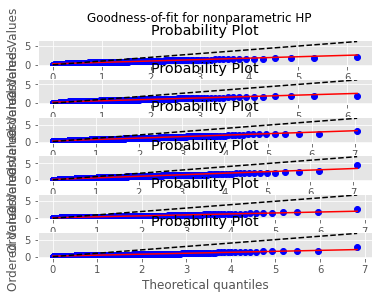

In [60]:
plot_resid(residuals, 6, 1)

In [61]:
ks_test(residuals)

[KstestResult(statistic=0.22042423543908374, pvalue=3.693714023088446e-15),
 KstestResult(statistic=0.22042423543908374, pvalue=3.693714023088446e-15),
 KstestResult(statistic=0.2181413944821471, pvalue=4.513400023623855e-34),
 KstestResult(statistic=0.19432277683307952, pvalue=5.357815383160771e-28),
 KstestResult(statistic=0.38256486594060013, pvalue=3.8521776835371356e-85),
 KstestResult(statistic=0.38256486594060013, pvalue=3.8521776835371356e-85)]

In [62]:
lb_test(residuals)

[     lb_stat  lb_pvalue
 3  11.560882   0.009049,
      lb_stat  lb_pvalue
 3  11.560882   0.009049,
      lb_stat  lb_pvalue
 3  13.146743    0.00433,
      lb_stat  lb_pvalue
 3  10.735035   0.013248,
     lb_stat  lb_pvalue
 3  1.254198   0.740037,
     lb_stat  lb_pvalue
 3  1.254198   0.740037]

In [63]:
ed_test(residuals)

[-5.583541046358494,
 -5.583541046358494,
 -8.010413116425577,
 -7.855182857873894,
 -8.246079032169973,
 -8.246079032169973]